# 2. Entendimiento y Preparacion de los datos


## 2.0 Carga de Datos y Librerias

En este momento vamos a cargar los datos planos del archivo fake_news_spanish.csv para utilizarlo así como importar las librerias necesarias para el resto del notebook.

In [75]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import scipy.stats as stats
import re, string
import scipy.sparse as sp

from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

from collections import Counter

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)

db_location = 'fake_news_spanish.csv'

news_df=pd.read_csv(db_location, sep=';', encoding = "UTF-8") 

news_df = news_df.astype(str)

news_df.head()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\caran\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\caran\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\caran\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018


## 2.1 Entendimiento de datos

// 	
Se describe de manera detallada el proceso de perfilamiento  y análisis de calidad de datos incluyendo gráficas o tablas, estadísticas descriptivas, acompañadas de una explicación. Además, se tiene la explicación de qué variables son categóricas y numéricas y valores atipicos en la distribución de los datos. Adicionalemente, el grupo justifica las posibles decisiones de transformación basadas en el perfilamiento de los datos
//


Para entender los datos procedemos a ver su estructura:


In [76]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57063 entries, 0 to 57062
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           57063 non-null  object
 1   Label        57063 non-null  object
 2   Titulo       57063 non-null  object
 3   Descripcion  57063 non-null  object
 4   Fecha        57063 non-null  object
dtypes: object(5)
memory usage: 2.2+ MB


Como podemos ver tenemos 5 columnas y 57 mil filas. De estas las mas importantes son las de "Label", "Titulo" y "Descripcion". Pues de estas vamos a obtener todas las variables para nuestro modelo de clasificación. Algo importante es que como podemos observar en la tabla anterior, no tenemos valores nulos en nuestras columnas. Por lo que no debemos preocuparnos por la completitud de los datos de entrenamiento.

### Estadísticas descriptivas

Para entender las noticias vamos a realizar estadísticas descriptivas de los textos. 

Para las variables las variables "Titulo" y "Descripcion" vamos a:
1. Dar su longitud total
2. La palabra más frecuente
3. La longitud de la palabra más grande y pequeña.

In [77]:
stats_textos = news_df.copy()

stats_textos['Longitud Titulo'] = [len(str(x)) for x in stats_textos['Titulo']]
stats_textos['Moda Titulo'] = [Counter([word.lower().strip(string.punctuation) for word in (str(i).split(' '))]).most_common()[0][0] for i in stats_textos['Titulo']]
stats_textos['Max Titulo'] = [[max([len(x) for x in str(i).split(' ')])][0] for i in stats_textos['Titulo']]
stats_textos['Min Titulo'] = [[min([len(x) for x in str(i).split(' ')])][0] for i in stats_textos['Titulo']]

stats_textos['Longitud Descripcion'] = [len(str(x)) for x in stats_textos['Descripcion']]
stats_textos['Moda Descripcion'] = [Counter([word.lower().strip(string.punctuation) for word in (str(i).split(' '))]).most_common()[0][0] for i in stats_textos['Descripcion']]
stats_textos['Max Descripcion'] = [[max([len(x) for x in str(i).split(' ')])][0] for i in stats_textos['Descripcion']]
stats_textos['Min Descripcion'] = [[min([len(x) for x in str(i).split(' ')])][0] for i in stats_textos['Descripcion']]


stats_textos.head()

,ID,Label,Titulo,Descripcion,Fecha,Longitud Titulo,Moda Titulo,Max Titulo,Min Titulo,Longitud Descripcion,Moda Descripcion,Max Descripcion,Min Descripcion
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023,77,the,9,2,218,el,13,1
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023,104,el,10,1,3260,que,18,1
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022,77,el,10,1,169,de,13,2
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022,110,a,12,1,133,que,15,2
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018,72,puigdemont,11,2,242,a,14,1


Algo de lo que nos podemos percatar a simple vista de los datos expuestos en la tabla anterior, es que la moda de tanto "Titulo" como "Descripcion" tiende a ser palabras vacías que no aportan a nuestro análisis. Por lo que deberemos eliminarlas en nuestra preparación de datos.

### Reporte con ydata_profiling

Para obtener un reporte mas detallado de del dataset vamos a generar un reporte con ydata_profiling:

In [78]:
# Si quiere ver el reporte de profiling, descomente las siguientes lineas

# from ydata_profiling import ProfileReport

# profile = ProfileReport(news_df, title="Profiling Report", minimal=True)
# profile.to_file("news_profile_report.html")

El resultado se puede observar en el archivo "news_profile_report.html".

En este archivo podemos resaltar varios aspectos de la información:
1. Se genera una alerta para la columna "ID", pues esta solo tiene el valor "ID" en todas sus filas. Por lo que es pertinente ignorarla y no usarla para nuestro entrenamiento.
2. Es alto el porcentaje total que ocupan en nuestros textos palabras vacías como: de, la, el, que, en, etc.

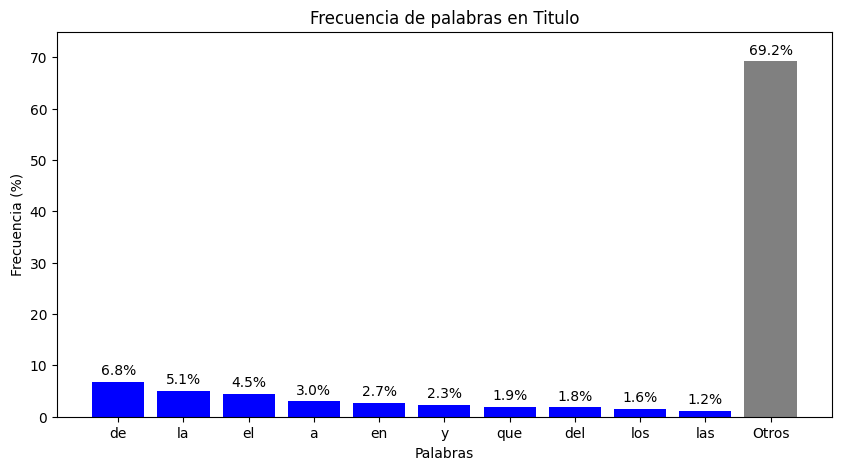

In [79]:
values_titulo = ["de", "la", "el", "a", "en", "y", "que", "del", "los", "las", "Otros"]
frequencies_titulo = [6.8, 5.1, 4.5, 3.0, 2.7, 2.3, 1.9, 1.8, 1.6, 1.2, 69.2]

plt.figure(figsize=(10, 5))
bars = plt.bar(values_titulo, frequencies_titulo, color=["blue" if v != "Otros" else "gray" for v in values_titulo])

plt.xlabel("Palabras")
plt.ylabel("Frecuencia (%)")
plt.title("Frecuencia de palabras en Titulo")
plt.ylim(0, 75)

plt.bar_label(bars, labels=[f"{freq}%" for freq in frequencies_titulo], padding=3)
    
plt.show()

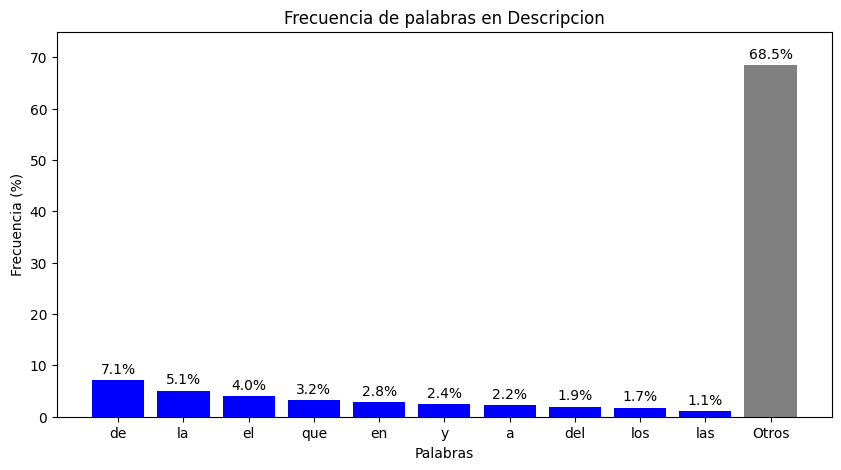

In [80]:
values_descripcion = ["de", "la", "el", "que", "en", "y", "a", "del", "los", "las", "Otros"]
frequencies_descripcion = [7.1, 5.1, 4.0, 3.2, 2.8, 2.4, 2.2, 1.9, 1.7, 1.1, 68.5]

plt.figure(figsize=(10, 5))
bars = plt.bar(values_descripcion, frequencies_descripcion, color=["blue" if v != "Otros" else "gray" for v in values_descripcion])

plt.xlabel("Palabras")
plt.ylabel("Frecuencia (%)")
plt.title("Frecuencia de palabras en Descripcion")
plt.ylim(0, 75)

plt.bar_label(bars, labels=[f"{freq}%" for freq in frequencies_descripcion], padding=3)
    
plt.show()

3. La longitud promedio de un "Titulo" es de 94.7, mientras que para una Descripción es de 243.5. Evidenciando que en promedio la descripción de una noticia va a ser 2 veces mas grande que su título.

### Descripción Variables

En cuanto a las variables de nuestros datos de entreno podemos ver que solo tenemos una variable numérica, esta siendo la variable objetivo donde:
1. 0 equivale a que la noticia es falsa y 1 equivale a que la noticia es verdadera. 
Adicionalmente tenemos variables categóricas Titulo y Descripcion, estas siendo las variables descriptivas donde:
2. Se tiene un conjunto de palabras en una cadena de texto.

### Valores atípicos  

Uno de los valores atípicos que detectamos en nuestros datos fue el uso de links o palabras como \*NUMBER\* y \*URL\* para describir valores de campos que no pudieron ser obtenidos.

A continuación vemos cuantos hay de cada uno:

In [81]:
mask_number = news_df["Titulo"].str.contains(r"\*NUMBER\*", na=False) | news_df["Descripcion"].str.contains(r"\*NUMBER\*", na=False)
num_filas_number = mask_number.sum()

mask_url = news_df["Titulo"].str.contains(r"\*URL\*", na=False) | news_df["Descripcion"].str.contains(r"\*URL\*", na=False)
num_filas_url = mask_url.sum()

mask_link = news_df["Titulo"].str.contains(r"http", na=False) | news_df["Descripcion"].str.contains(r"http", na=False)
num_filas_link = mask_link.sum()

print(f"Número de filas con '*NUMBER*': {num_filas_number}")
print(f"Número de filas con '*URL*': {num_filas_url}")
print(f"Número de filas con 'http': {num_filas_link}")
print(f"Total de filas con valores atípicos: {num_filas_number + num_filas_url + num_filas_link}")


Número de filas con '*NUMBER*': 164
Número de filas con '*URL*': 5
Número de filas con 'http': 3
Total de filas con valores atípicos: 172


Dado que estos valores no aportan información de si una noticia es falsa o verdadera, y como podemos observar, hay varias filas que contienen estos valores. Tomamos la decision de que no vamos a tomar en cuenta estas filas para evitar errores en nuestras predicciones finales. 

## 2.2 Preparacion de datos

Para preparar los datos vamos a seguir los pasos de procesamiento de texto tanto para el titúlo asi como las descripciones.

### 2.2.0 Pre-procesamiento de los datos

Para esta sección vamos a limpiar un poco los datos antes de prepararlos para el modelo

1. Vamos a eliminar los duplicados ya que esto no le va a aportar información adicional al modelo.

In [82]:
news_df = news_df.drop_duplicates()
news_df.shape[0]

56618

2. Vamos a seleccionar solo 3 columnas: Label, Titulo y Descripción. Esta decision se tomó ya que la fecha aunque aporta información acerca del dato, no va a aportar información acerca de si la noticia es falsa o no.

In [83]:
news_df = news_df[["Label", "Titulo", "Descripcion"]]

### 2.2.1 Eliminación de Ruido

Para eliminar el ruido vamos a eliminar cualquier instancia de caracter especial ($, @, ..., etc) y/o caracter de separacion (',', '.', ..., etc). Tambien vamos a estandarizar los caracteres para que todos se encuentren en minusculas. Se tomó la desicion de dejar las palabras con acento ya que en el español es una parte importante del significado de lo que se transmite en las palabras.


In [84]:
def eliminar_ruido(words):
    new_words = []
    stop_words_set = set(stopwords.words('spanish'))
    for word in words:
        if word is not None:
            new_word = word.lower()
            if new_word not in stop_words_set: 
                new_word = re.sub(r'[^\w\s]', '', new_word)
                if new_word != '':
                    new_words.append(new_word)
    return new_words

def preprocessing(words):
    words = eliminar_ruido(words)
    return words

### 2.2.2 Tokenización 

Se va a tokenizar cada palabra y se va a guardar en una lista para trabajar así de ahora en adelante

In [85]:
news_df['TituloTok'] = news_df['Titulo'].apply(word_tokenize)
news_df['DescripTok'] = news_df['Descripcion'].apply(word_tokenize)

news_df.head()

,Label,Titulo,Descripcion,TituloTok,DescripTok
0,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,"['The, Guardian, ', va, con, Sánchez, :, 'Euro...","[El, diario, británico, publicó, este, pasado,..."
1,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,"[REVELAN, QUE, EL, GOBIERNO, NEGOCIO, LA, LIBE...","[REVELAN, QUE, EL, GOBIERNO, NEGOCIO, LA, LIBE..."
2,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,"[El, 'Ahora, o, nunca, ', de, Joan, Fuster, so...","[El, valencianismo, convoca, en, Castelló, su,..."
3,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...","[Iglesias, alienta, a, Yolanda, Díaz, ,, ERC, ...","[En, política, ,, igual, que, hay, que, negoci..."
4,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...","[Puigdemont, :, 'No, sería, ninguna, tragedia,...","[En, una, entrevista, en, El, Punt, Avui, ,, e..."


In [86]:
#Aplicación de reducción de ruido

news_df['TituloLimpio']=news_df['TituloTok'].apply(preprocessing)
news_df['DescripcionLimpio']=news_df['DescripTok'].apply(preprocessing)

news_df.head()


,Label,Titulo,Descripcion,TituloTok,DescripTok,TituloLimpio,DescripcionLimpio
0,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,"['The, Guardian, ', va, con, Sánchez, :, 'Euro...","[El, diario, británico, publicó, este, pasado,...","[the, guardian, va, sánchez, europa, necesita,...","[diario, británico, publicó, pasado, jueves, e..."
1,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,"[REVELAN, QUE, EL, GOBIERNO, NEGOCIO, LA, LIBE...","[REVELAN, QUE, EL, GOBIERNO, NEGOCIO, LA, LIBE...","[revelan, gobierno, negocio, liberación, mirel...","[revelan, gobierno, negocio, liberación, mirel..."
2,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,"[El, 'Ahora, o, nunca, ', de, Joan, Fuster, so...","[El, valencianismo, convoca, en, Castelló, su,...","[ahora, nunca, joan, fuster, estatuto, valenci...","[valencianismo, convoca, castelló, fiesta, gra..."
3,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...","[Iglesias, alienta, a, Yolanda, Díaz, ,, ERC, ...","[En, política, ,, igual, que, hay, que, negoci...","[iglesias, alienta, yolanda, díaz, erc, eh, bi...","[política, igual, negociar, empresarios, negoc..."
4,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...","[Puigdemont, :, 'No, sería, ninguna, tragedia,...","[En, una, entrevista, en, El, Punt, Avui, ,, e...","[puigdemont, no, ninguna, tragedia, repetición...","[entrevista, punt, avui, líder, jxcat, desdram..."


In [88]:
news_df = news_df[["Label", "TituloLimpio", "DescripcionLimpio"]]
news_df.head()

,Label,TituloLimpio,DescripcionLimpio
0,1,"[the, guardian, va, sánchez, europa, necesita,...","[diario, británico, publicó, pasado, jueves, e..."
1,0,"[revelan, gobierno, negocio, liberación, mirel...","[revelan, gobierno, negocio, liberación, mirel..."
2,1,"[ahora, nunca, joan, fuster, estatuto, valenci...","[valencianismo, convoca, castelló, fiesta, gra..."
3,1,"[iglesias, alienta, yolanda, díaz, erc, eh, bi...","[política, igual, negociar, empresarios, negoc..."
4,0,"[puigdemont, no, ninguna, tragedia, repetición...","[entrevista, punt, avui, líder, jxcat, desdram..."


### 2.2.3 Lematización

Ahora vamos a lematizar las palabras, o de otra forma vamos a aplanar el lenguaje de las mismas (Corrió -> Correr). Así tambien como devolviendo las oraciones a texto de tipo Str para trabajar con ellas más adelante.

In [89]:
def lemmaWords(words):
    
    lem = WordNetLemmatizer()
    
    result = ""
    for word in words:
        result += lem.lemmatize(word, pos='v') + " "
        
    return result

news_df['TituloLemm']=news_df['TituloLimpio'].apply(lemmaWords)
news_df['DescripcionLemm']=news_df['DescripcionLimpio'].apply(lemmaWords)

news_df.head()

,Label,TituloLimpio,DescripcionLimpio,TituloLemm,DescripcionLemm
0,1,"[the, guardian, va, sánchez, europa, necesita,...","[diario, británico, publicó, pasado, jueves, e...",the guardian va sánchez europa necesita apuest...,diario británico publicó pasado jueves editori...
1,0,"[revelan, gobierno, negocio, liberación, mirel...","[revelan, gobierno, negocio, liberación, mirel...",revelan gobierno negocio liberación mireles ca...,revelan gobierno negocio liberación mireles ca...
2,1,"[ahora, nunca, joan, fuster, estatuto, valenci...","[valencianismo, convoca, castelló, fiesta, gra...",ahora nunca joan fuster estatuto valenciano cu...,valencianismo convoca castelló fiesta grande c...
3,1,"[iglesias, alienta, yolanda, díaz, erc, eh, bi...","[política, igual, negociar, empresarios, negoc...",iglesias alienta yolanda díaz erc eh bildu neg...,política igual negociar empresarios negociar g...
4,0,"[puigdemont, no, ninguna, tragedia, repetición...","[entrevista, punt, avui, líder, jxcat, desdram...",puigdemont no ninguna tragedia repetición elec...,entrevista punt avui líder jxcat desdramatizad...


In [90]:
news_df = news_df[["Label", "TituloLemm", "DescripcionLemm"]]
news_df.head()

,Label,TituloLemm,DescripcionLemm
0,1,the guardian va sánchez europa necesita apuest...,diario británico publicó pasado jueves editori...
1,0,revelan gobierno negocio liberación mireles ca...,revelan gobierno negocio liberación mireles ca...
2,1,ahora nunca joan fuster estatuto valenciano cu...,valencianismo convoca castelló fiesta grande c...
3,1,iglesias alienta yolanda díaz erc eh bildu neg...,política igual negociar empresarios negociar g...
4,0,puigdemont no ninguna tragedia repetición elec...,entrevista punt avui líder jxcat desdramatizad...


### 2.2.4 Vectorización de los datos

Vamos a vectorizar cada oracion tanto de los titulos como las descripciones para que puedan ser ingresados en los diferentes algoritmos de predicciones.

In [91]:
vectorizer = TfidfVectorizer()
tit = vectorizer.fit_transform(news_df['TituloLemm'])
desc = vectorizer.fit_transform(news_df['DescripcionLemm'])

Posteriormente vamos a realizar un stack (Titulo - Descripcion) para que puedan entrar juntos al modelo.

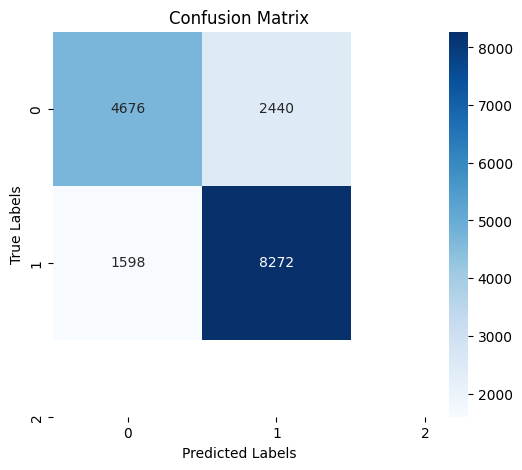

In [92]:
X = sp.hstack([tit, desc])
Y = news_df["Label"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

neigh = KNeighborsClassifier(n_neighbors=7)
neigh = neigh.fit(X_train, Y_train)

y_pred = neigh.predict(X_test)

cm = confusion_matrix(Y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [93]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

print(classification_report(Y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.75      0.66      0.70      7116
           1       0.77      0.84      0.80      9870

    accuracy                           0.76     16986
   macro avg       0.76      0.75      0.75     16986
weighted avg       0.76      0.76      0.76     16986



In [94]:
# Crear el modelo Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf.fit(X_train, Y_train)

y_pred = rf.predict(X_test)

print(classification_report(Y_test, y_pred)) 


              precision    recall  f1-score   support

           0       0.92      0.85      0.88      7116
           1       0.90      0.95      0.92      9870

    accuracy                           0.91     16986
   macro avg       0.91      0.90      0.90     16986
weighted avg       0.91      0.91      0.91     16986

